### PORT 1a - energy average depositions

looking at loading in all the relevant signal events and scooping out the signal events. lets make a script

In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
import core.functions as func
#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook


#%matplotlib widget
#import ipympl

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from tqdm import tqdm


In [25]:
 # lets load in the post 1a tracks
MC_signals = np.load('port_1a_signal_evts.npy')
MC_lost = np.load('port_1a_isaura_lost_evts.npy')
signals = MC_signals # be careful with the multiplication here
print(np.sort(signals))

[      8      26      33 ... 2990294 2990307 2990320]


In [11]:
def collect_signal_events(folder_path, event_numbers):

    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    i = 0

    for file in tqdm(file_names):

        file_path = folder_path + file
        df = dstio.load_dst(file_path, 'RECO', 'Events')
        if (i == 0):
            signal_df = df[df['event'].isin(event_numbers)]
            i += 1
        else:
            signal_df = signal_df.append(df[df['event'].isin(event_numbers)], ignore_index = True)
        
    return signal_df
            

def collect_signal_events_MC(folder_path, event_numbers):

    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    i = 0

    for file in tqdm(file_names):

        file_path = folder_path + file
        df = mcio.load_mchits_df(file_path).reset_index()
        if (i == 0):
            signal_df = df[df['event_id'].isin(event_numbers)]
            i += 1
        else:
            signal_df = signal_df.append(df[df['event_id'].isin(event_numbers)], ignore_index = True)
        
    return signal_df

In [26]:
#signal_df = collect_signal_events('testing_data/beersheba/', signals)
signal_df = collect_signal_events_MC('testing_data/beersheba/', MC_signals)


100%|██████████| 300/300 [00:46<00:00,  6.44it/s]


NameError: name 'collect_lost_events_MC' is not defined

In [27]:
lost_df = collect_signal_events_MC('testing_data/beersheba/', MC_lost)

100%|██████████| 300/300 [00:27<00:00, 10.74it/s]


In [16]:
display(signal_df)
print(np.unique(signal_df.event_id.values))

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,2040002,6,0,337.236969,316.893219,577.276428,0.371902,0.000103,ACTIVE
1,2040002,6,1,180.341843,418.185425,686.191711,1.093039,0.000120,ACTIVE
2,2040002,23,0,180.341934,418.185425,686.191589,1.093094,0.000021,ACTIVE
3,2040002,22,0,180.341766,418.185333,686.191528,1.093094,0.000043,ACTIVE
4,2040002,21,0,180.341644,418.185516,686.191711,1.093096,0.000044,ACTIVE
...,...,...,...,...,...,...,...,...,...
2706629,1310327,85,0,195.093964,264.369141,358.266968,1.217912,0.000046,ACTIVE
2706630,1310327,84,0,195.093948,264.368958,358.266724,1.217897,0.000022,ACTIVE
2706631,1310327,84,1,195.093735,264.368500,358.266937,1.217938,0.000520,ACTIVE
2706632,1310327,83,0,195.094421,264.369141,358.265869,1.217925,0.000235,ACTIVE


[      8      26      33 ... 2990294 2990307 2990320]


In [17]:
print(len(np.unique(signal_df.event_id.to_numpy())))

6939


In [18]:
#df_total_E = []
#for event, df in signal_df.groupby("event"):
#    print("Event: {}\n Total energy: {} MeV".format(event, df.E.sum()))
#    df_total_E.append(df.E.sum())

# MC
df_total_E = []
event_IDs = []
for event, df in signal_df.groupby("event_id"):
    print("Event: {}\n Total energy: {} MeV".format(event, df.energy.sum()))
    df_total_E.append(df.energy.sum())
    event_IDs.append(event)

Event: 8
 Total energy: 1.3181968927383423 MeV
Event: 26
 Total energy: 0.5088149905204773 MeV
Event: 33
 Total energy: 0.6293253302574158 MeV
Event: 76
 Total energy: 1.537204384803772 MeV
Event: 80
 Total energy: 0.4305400252342224 MeV
Event: 88
 Total energy: 0.7648193836212158 MeV
Event: 97
 Total energy: 0.5005431771278381 MeV
Event: 99
 Total energy: 1.5925064086914062 MeV
Event: 111
 Total energy: 0.4093673825263977 MeV
Event: 114
 Total energy: 0.5831881165504456 MeV
Event: 135
 Total energy: 1.5925064086914062 MeV
Event: 140
 Total energy: 0.48902222514152527 MeV
Event: 156
 Total energy: 1.6340579986572266 MeV
Event: 168
 Total energy: 0.43784099817276 MeV
Event: 170
 Total energy: 1.5925065279006958 MeV
Event: 180
 Total energy: 0.5831881165504456 MeV
Event: 182
 Total energy: 0.5831881761550903 MeV
Event: 214
 Total energy: 1.5925065279006958 MeV
Event: 242
 Total energy: 1.8128550052642822 MeV
Event: 246
 Total energy: 0.5831881165504456 MeV
Event: 255
 Total energy: 0.434

Text(0.5, 1.0, 'UNSuccessful Signal events total Energy per event - MC')

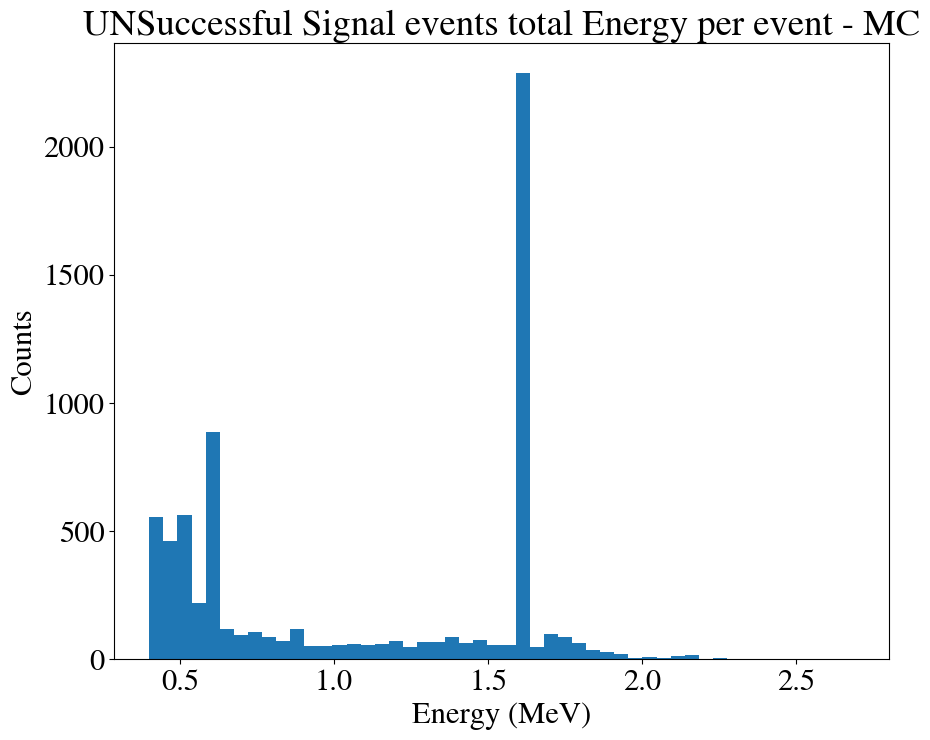

In [19]:
plt.hist(df_total_E, bins = 50)
plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.title("UNSuccessful Signal events total Energy per event - MC")

In [15]:
df_total_E = np.array(df_total_E)
# create a mask for events < 1 MeV
p = np.where(df_total_E < 1)
#print(p)
print("Events with low E")
print(np.array(event_IDs)[p])
# and for when in area of interest
q = np.where(np.logical_and(df_total_E>1.5, df_total_E<1.7))
#print(len(q[0]))


Events with low E
[    312   60030  220042  240038  240256  280184  300084  320202  340338
  520060  520270  540212  560190  600100  620312  640036  640092  640236
  660092  700172  780056  860076  920264  960194  960312  980040 1020128
 1040084 1060048 1060238 1080002 1080120 1100230 1140114 1160212 1160240
 1200018 1200102 1200200 1220090 1220212 1240092 1260020 1260042 1260180
 1320254 1360228 1400154 1400174 1400222 1400284 1420008 1460308 1480170
 1480206 1520024 1520058 1520106 1540176 1540180 1580254 1640290 1700310
 1740284 1760090 1760174 1820096 1840034 1860202 1880320 1920152 1940206
 1980012 2020232 2040116 2080170 2120128 2140194 2140242 2180088 2220006
 2240086 2260108 2300036 2320162 2320208 2380290 2460226 2520022 2540222
 2560308 2640170 2640188 2660048 2660206 2680228 2720050 2740314 2760254
 2920212 2960328]


In [16]:
folder_path = 'testing_data/beersheba/'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
df_trs = []

for file in file_names:
    file_path = folder_path + file
    MC_file = pd.read_hdf(file_path, 'MC/particles')
    df_trs.append(MC_file)
df_trs = pd.concat(df_trs, axis = 0, ignore_index = True)
    

NoSuchNodeError: group ``/`` does not have a child named ``Tracking``

Text(0.5, 0, 'Energy (MeV) per hit')

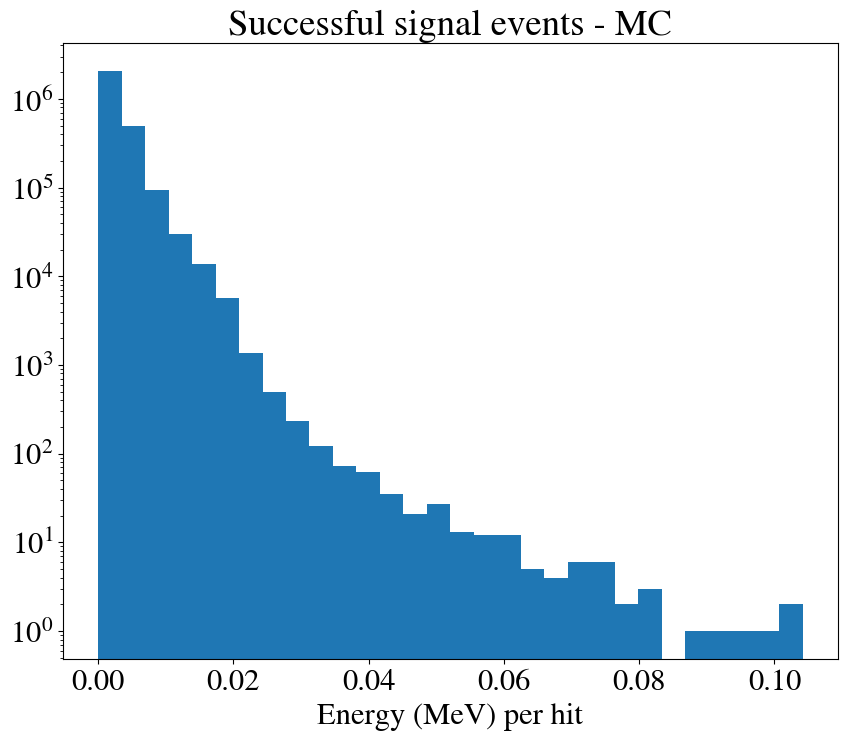

In [20]:
#plt.hist(signal_df.E.values, bins = 30, log = True)
#plt.title("Unsuccessful signal events")
#plt.xlabel("Energy (MeV) per hit")


### MC
plt.hist(signal_df.energy.values, bins = 30, log = True)
plt.title("Successful signal events - MC")
plt.xlabel("Energy (MeV) per hit")


Index(['x', 'y', 'z', 'time', 'energy'], dtype='object')
149


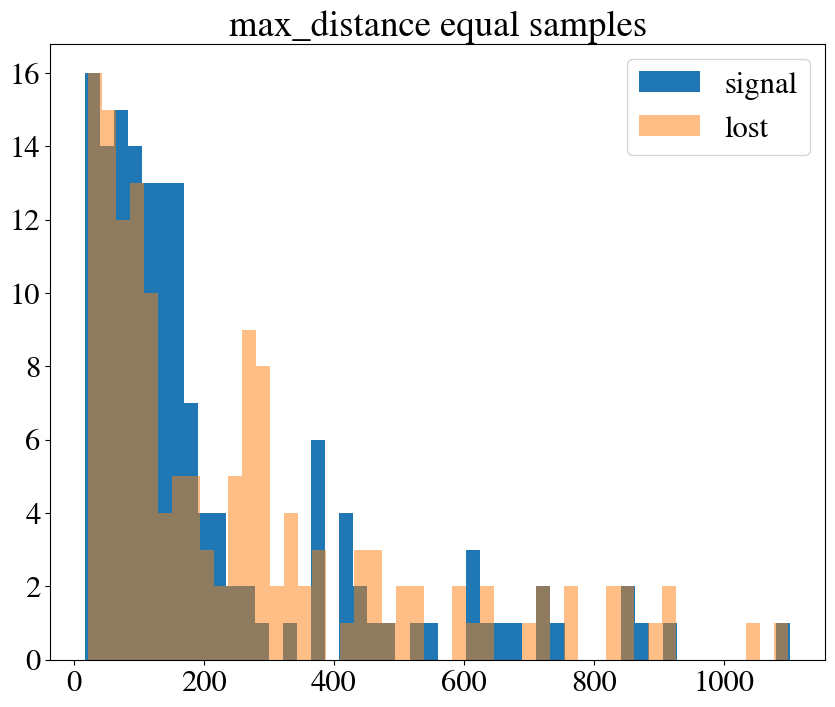

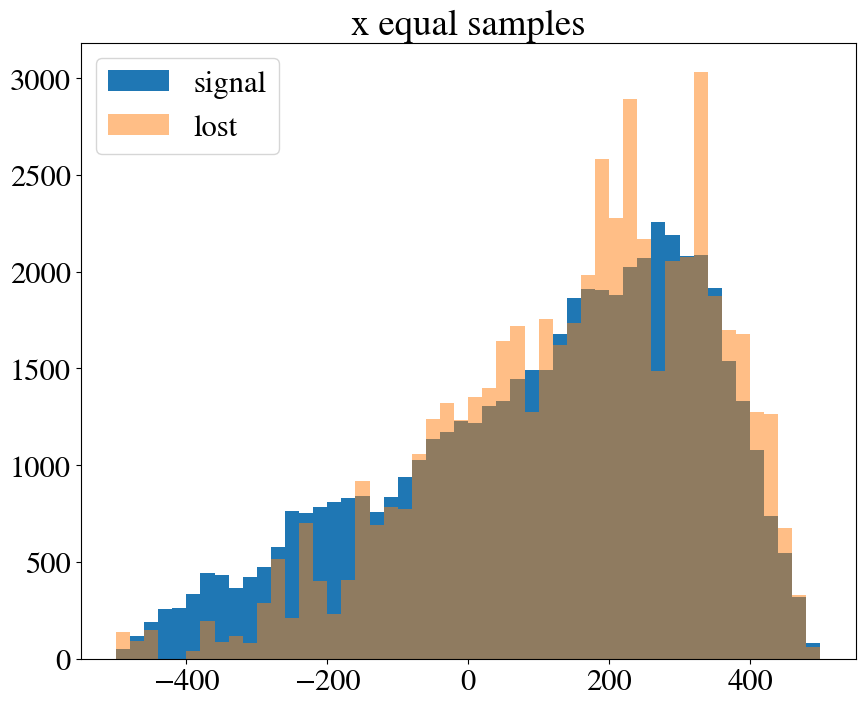

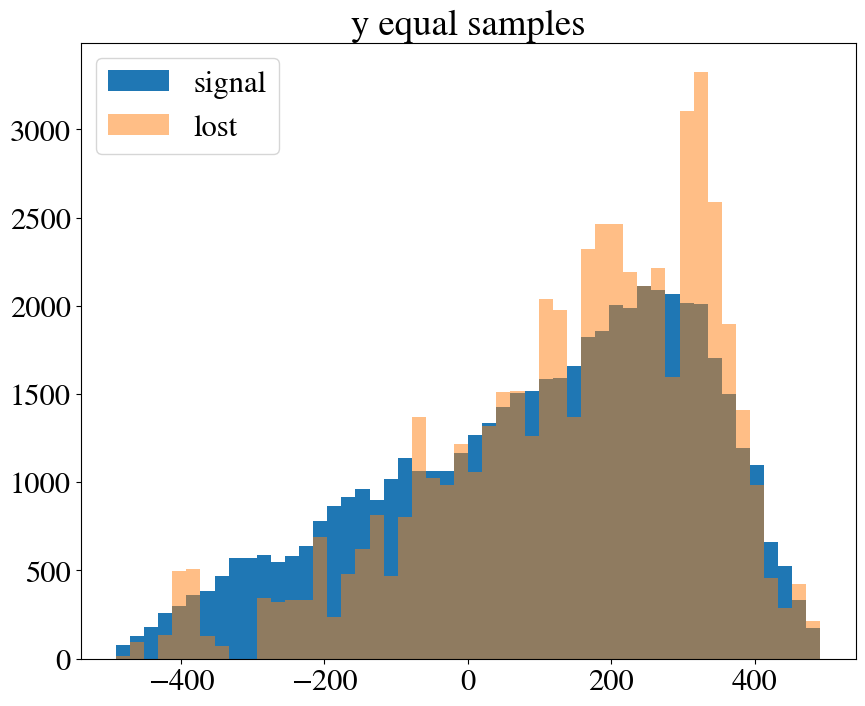

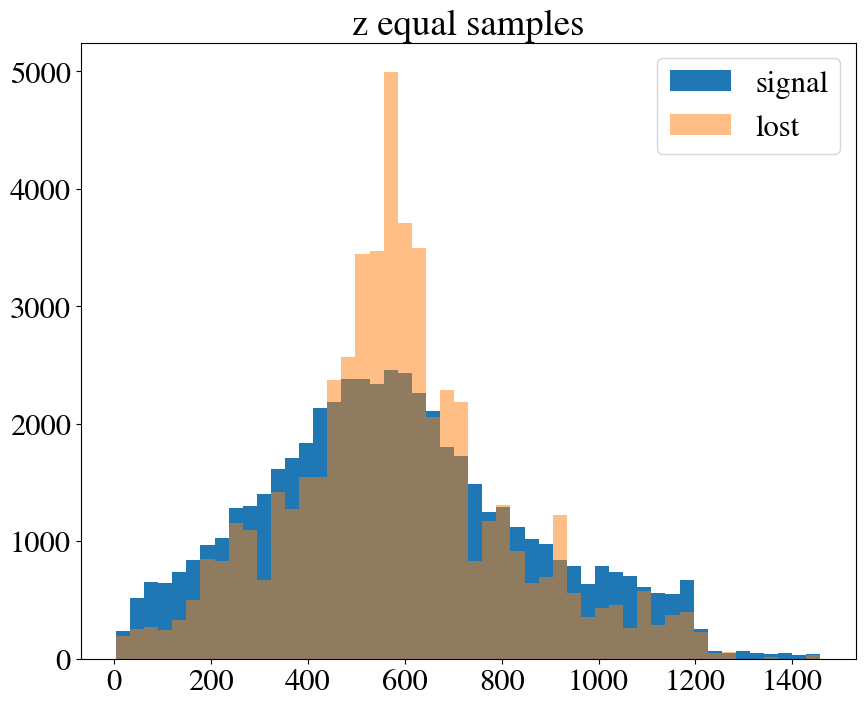

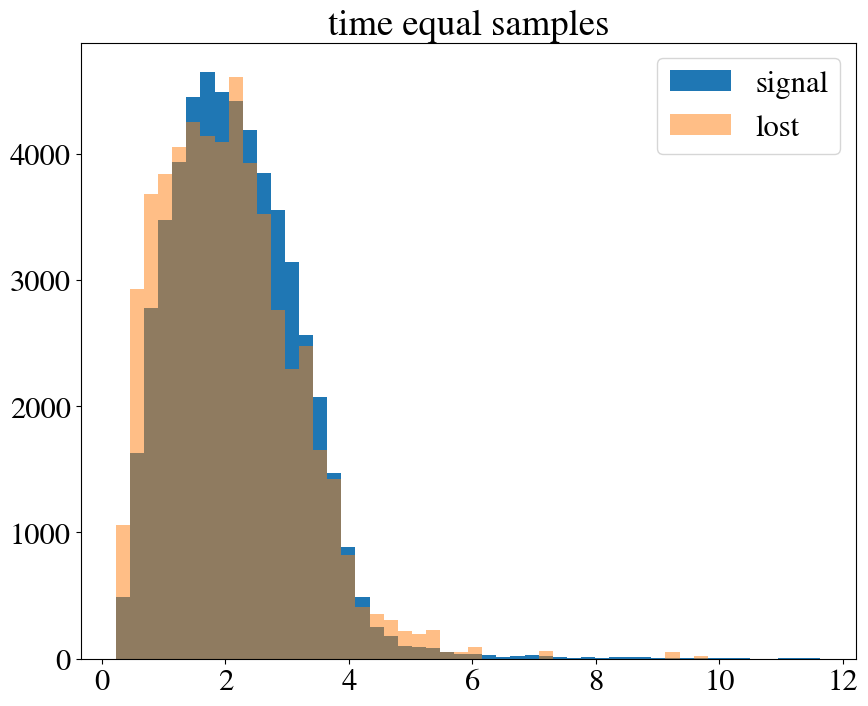

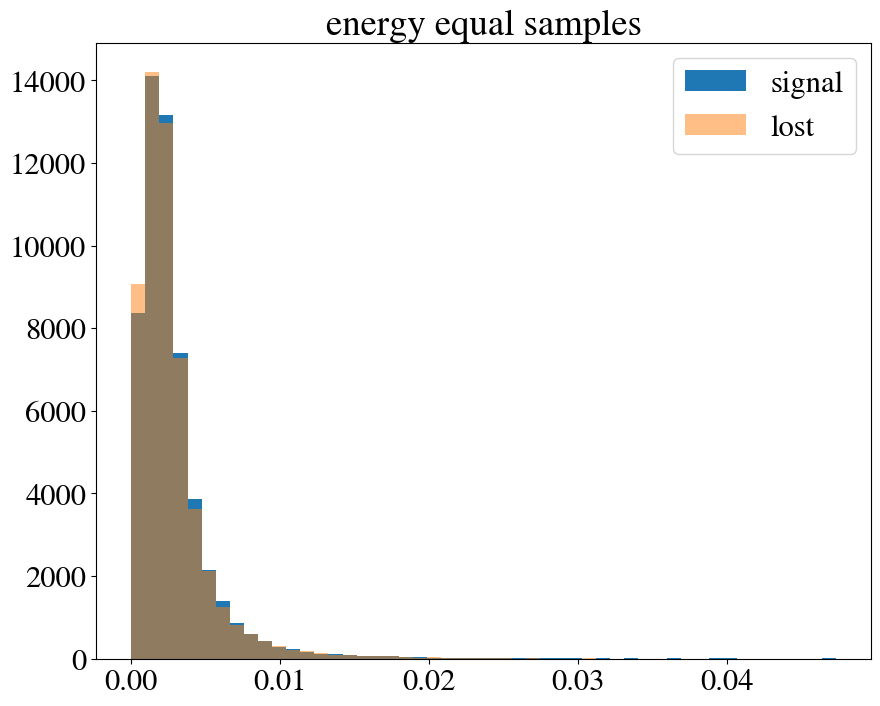

In [95]:
columns = (signal_df.columns)[3:][:-1]
print(columns)


from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
# calculate lengths of tracks
max_track_sig = []
for event, df in signal_df.groupby("event_id"):
    points = df[['x','y','z']].to_numpy()
    # collect convexhull points
    hull = ConvexHull(points)

    hullpoints = points[hull.vertices,:]

    hdist = cdist(hullpoints, hullpoints, metric='euclidean')
    max_dist = np.max(hdist)
    max_track_sig.append(max_dist)

max_track_lost = []
for event, df in lost_df.groupby("event_id"):
    points = df[['x','y','z']].to_numpy()
    # collect convexhull points
    hull = ConvexHull(points)

    hullpoints = points[hull.vertices,:]

    hdist = cdist(hullpoints, hullpoints, metric='euclidean')
    max_dist = np.max(hdist)
    max_track_lost.append(max_dist)


print(len(max_track_lost))
plt.hist(max_track_sig[:len(max_track_lost)], bins = 50, log = log_check, label = 'signal')
plt.hist(max_track_lost, bins = 50, log = log_check, alpha = 0.5, label = 'lost')
plt.title("{} equal samples".format('max_distance'))
plt.legend()
plt.show()


log_check = False
for i in range(len(columns)):
    # make the signal sample same size as lost_df
    lost_df_evts = lost_df[str(columns[i])].values
    
    events_of_interest = np.array(signal_df[str(columns[i])].values)
    np.random.shuffle(events_of_interest)
    events_of_interest = events_of_interest[:len(lost_df_evts)]

    # take maximum and minimum to set limits (for equal binning)
    min_val = min(min(lost_df_evts), min(events_of_interest))
    max_val = max(max(lost_df_evts), max(events_of_interest))

    plt.hist(events_of_interest, bins = 50, log = log_check, label = 'signal', range = (min_val, max_val))
    plt.hist(lost_df_evts, bins = 50, log = log_check, alpha = 0.5, label = 'lost', range = (min_val, max_val))
    plt.title("{} equal samples".format(str(columns[i])))
    plt.legend()
    plt.show()


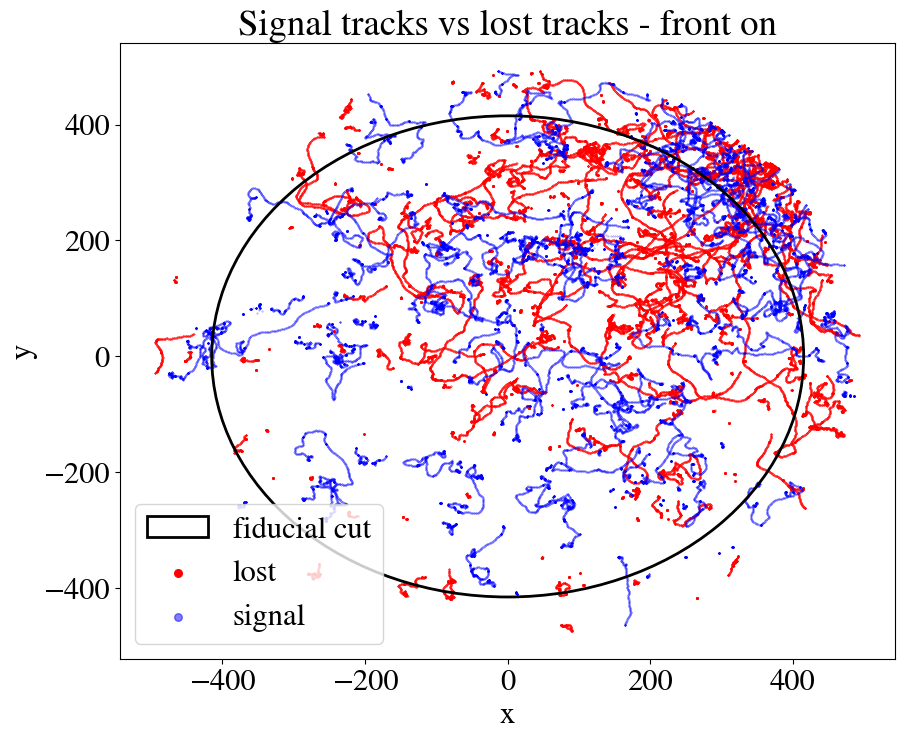

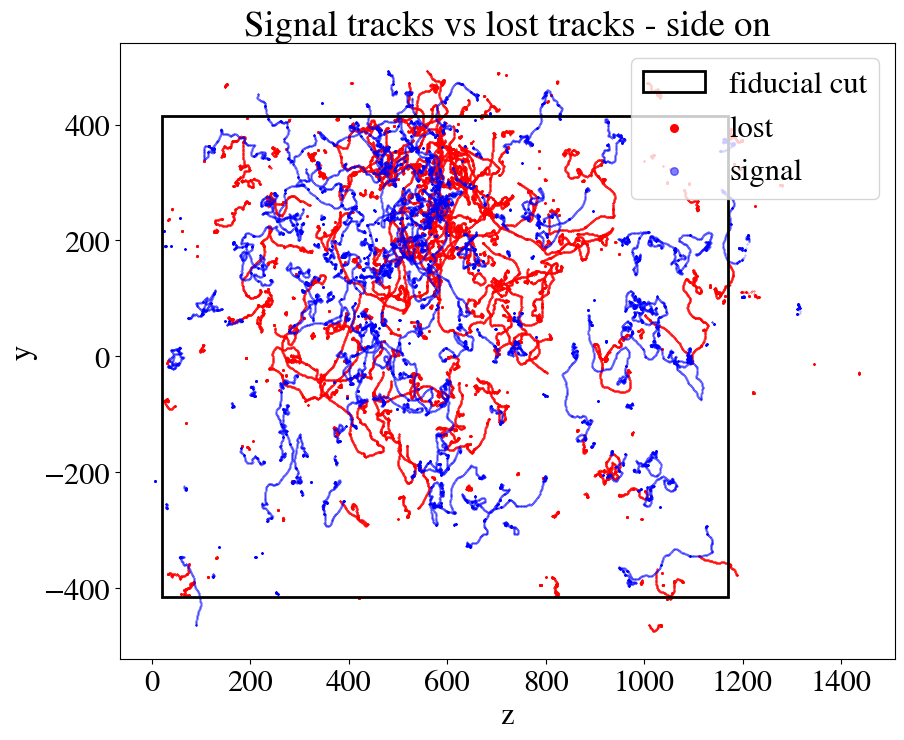

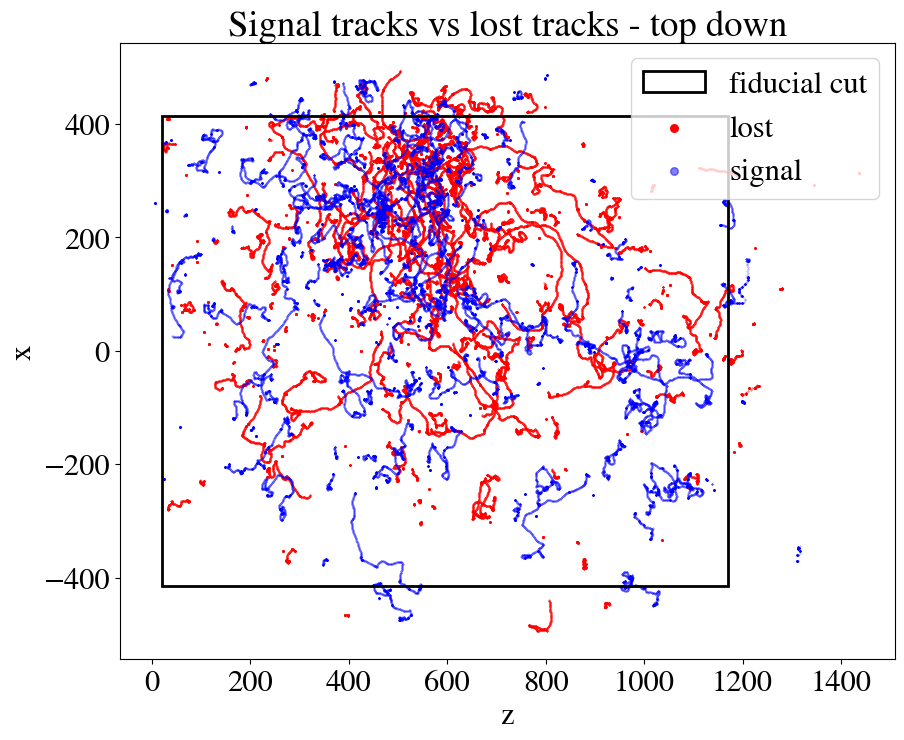

In [75]:

plt.scatter(lost_df['x'].values, lost_df['y'].values, label = 'lost', color = 'red', s = 0.1)
plt.scatter(signal_df['x'].values[:len(lost_df_evts)], signal_df['y'].values[:len(lost_df_evts)], label = 'signal', color = 'blue', alpha = 0.5, s= 0.1)

circle = plt.Circle((0,0), 415, color = 'black', fill=False, linewidth = 2, label = 'fiducial cut')
plt.gca().add_patch(circle)
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
plt.title("Signal tracks vs lost tracks - front on")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.scatter(lost_df['z'].values, lost_df['y'].values, label = 'lost', color = 'red', s = 0.1)
plt.scatter(signal_df['z'].values[:len(lost_df_evts)], signal_df['y'].values[:len(lost_df_evts)], label = 'signal', color = 'blue', alpha = 0.5, s= 0.1)

rect = plt.Rectangle((20,-415), 1150, 830, color = 'black', fill = False, linewidth = 2, label = 'fiducial cut')
plt.gca().add_patch(rect)
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
plt.title("Signal tracks vs lost tracks - side on")
plt.xlabel('z')
plt.ylabel('y')
plt.show()


plt.scatter(lost_df['z'].values, lost_df['x'].values, label = 'lost', color = 'red', s = 0.1)
plt.scatter(signal_df['z'].values[:len(lost_df_evts)], signal_df['x'].values[:len(lost_df_evts)], label = 'signal', color = 'blue', alpha = 0.5, s= 0.1)
rect1 = plt.Rectangle((20,-415), 1150, 830, color = 'black', fill = False, linewidth = 2, label = 'fiducial cut')

plt.gca().add_patch(rect1)
plt.title("Signal tracks vs lost tracks - top down")
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
plt.xlabel('z')
plt.ylabel('x')
plt.show()

An aside, why are there so many low E (0.5 MeV) events that made it through? lets check

In [11]:
display(signal_df)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,2040116,18,0,330.983215,259.039642,560.579590,0.506002,0.000288,ACTIVE
1,2040116,37,0,330.983215,259.039764,560.579773,0.506065,0.000033,ACTIVE
2,2040116,36,0,330.983307,259.039581,560.579590,0.506034,0.000033,ACTIVE
3,2040116,35,0,330.983246,259.039520,560.579468,0.506097,0.000012,ACTIVE
4,2040116,34,0,330.983215,259.039734,560.579651,0.506032,0.000046,ACTIVE
...,...,...,...,...,...,...,...,...,...
53576,280184,35,23,265.580994,-417.186737,421.041901,2.935957,0.001155,ACTIVE
53577,280184,35,24,265.583649,-417.180817,421.040283,2.936136,0.001196,ACTIVE
53578,280184,35,25,265.585022,-417.181610,421.036469,2.936266,0.001308,ACTIVE
53579,280184,35,26,265.584351,-417.180054,421.035706,2.936345,0.001077,ACTIVE


In [12]:
p1a_MC = func.positron_scraper('testing_data/beersheba/')

In [13]:
# 
df_total_E = np.array(df_total_E)
event_IDs = np.array(event_IDs)
low_E_IDS = event_IDs[df_total_E < 0.6]

In [14]:
low_E_evts = p1a_MC[p1a_MC.event_id.isin(low_E_IDS)]
display(low_E_evts)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
34901,600100,48,e+,False,46,386.698730,404.668335,522.084900,0.068762,386.683807,...,-0.194061,0.437253,-0.250862,0.0,0.0,-0.0,0.232575,0.099998,conv,annihil
73080,240256,59,e+,False,57,408.135284,377.927185,549.791687,0.088857,408.221802,...,0.810748,-0.086050,0.010719,-0.0,-0.0,0.0,0.451265,0.241699,conv,annihil
79448,2520022,48,e+,False,46,-132.171097,-7.626649,-52.531067,2.954356,-132.064011,...,-1.041982,0.075965,-0.890550,0.0,-0.0,-0.0,0.953821,0.634183,conv,annihil
729088,2660206,54,e+,False,52,392.595764,420.588898,534.365601,0.070515,392.595367,...,0.052748,0.131268,-0.385373,0.0,0.0,0.0,0.144475,0.038735,conv,annihil
596027,1400154,55,e+,False,53,322.519745,-344.321472,1111.709595,3.150798,322.570251,...,-0.152839,0.034469,0.074600,-0.0,0.0,0.0,0.028661,0.884371,conv,annihil
606807,1400284,32,e+,False,30,396.117279,401.534607,536.101624,0.013343,396.134003,...,0.451346,0.944362,0.713530,-0.0,-0.0,0.0,0.854936,0.719412,conv,annihil
690967,960312,91,e+,False,89,430.392822,366.419556,529.766113,0.149569,430.403351,...,0.638481,-0.705508,-0.293756,0.0,0.0,0.0,0.608292,0.395604,conv,annihil
486490,1200018,66,e+,False,64,394.574432,400.045929,525.567932,0.036624,394.493744,...,-0.763674,-0.109985,0.156998,-0.0,0.0,0.0,0.427650,0.250722,conv,annihil
500205,1200200,24,e+,False,22,-373.497437,348.275055,413.127441,2.610416,-373.716125,...,-1.128909,-0.108263,-0.182489,0.0,-0.0,0.0,0.746211,0.575708,conv,annihil
459190,1080002,104,e+,False,102,405.871033,411.550568,508.537476,0.101828,405.498596,...,-0.993246,-1.017732,-1.430594,0.0,0.0,0.0,1.569875,0.992712,conv,annihil


Text(0.5, 1.0, 'kin_E - low_E ')

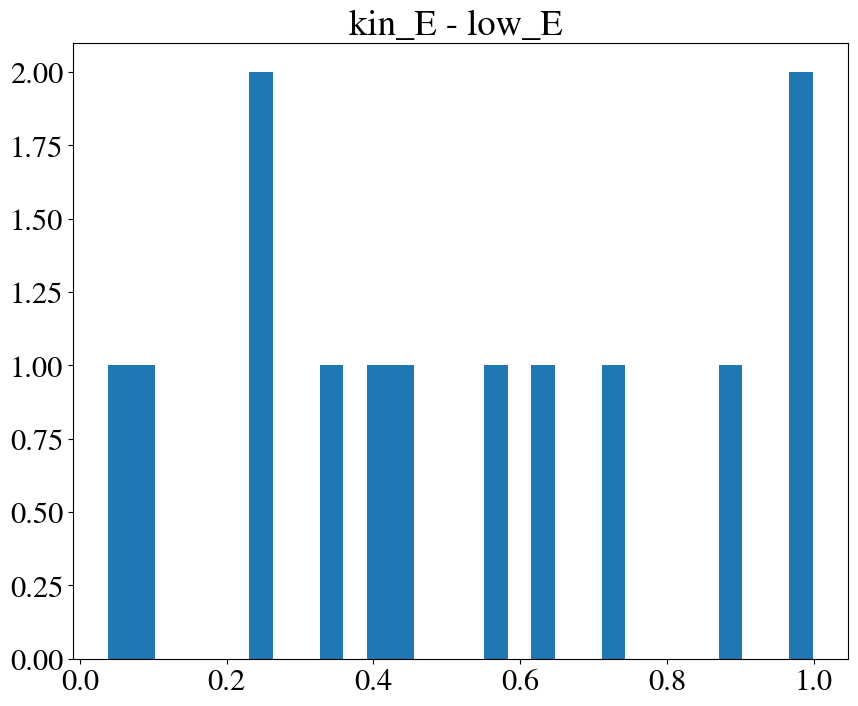

In [18]:
plt.hist(low_E_evts.length.values, bins = 30)
plt.title("kin_E - low_E ")

(array([7.266e+03, 4.020e+02, 3.460e+02, 3.560e+02, 3.730e+02, 3.690e+02,
        3.110e+02, 3.170e+02, 3.560e+02, 3.010e+02, 3.440e+02, 2.960e+02,
        3.020e+02, 2.560e+02, 2.580e+02, 2.330e+02, 1.990e+02, 1.820e+02,
        1.390e+02, 1.340e+02, 1.360e+02, 1.090e+02, 9.900e+01, 7.100e+01,
        4.700e+01, 3.700e+01, 2.200e+01, 1.500e+01, 3.000e+00, 5.000e+00]),
 array([1.57285212e-05, 1.83829536e+01, 3.67658920e+01, 5.51488304e+01,
        7.35317688e+01, 9.19147034e+01, 1.10297646e+02, 1.28680588e+02,
        1.47063522e+02, 1.65446457e+02, 1.83829391e+02, 2.02212341e+02,
        2.20595276e+02, 2.38978210e+02, 2.57361145e+02, 2.75744080e+02,
        2.94127014e+02, 3.12509949e+02, 3.30892914e+02, 3.49275848e+02,
        3.67658783e+02, 3.86041718e+02, 4.04424652e+02, 4.22807587e+02,
        4.41190521e+02, 4.59573456e+02, 4.77956421e+02, 4.96339355e+02,
        5.14722290e+02, 5.33105225e+02, 5.51488159e+02], dtype=float32),
 <BarContainer object of 30 artists>)

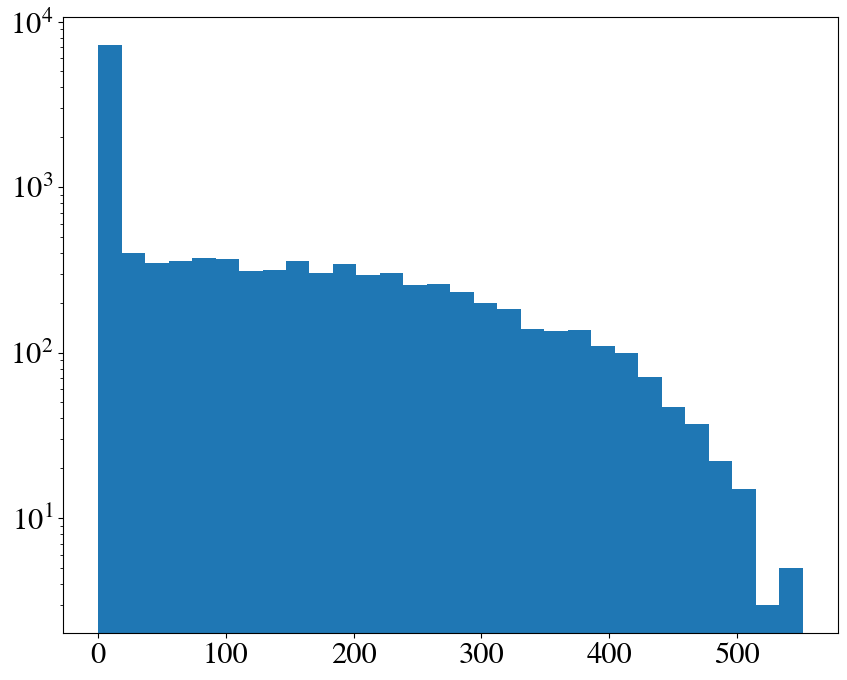

In [20]:
plt.hist(p1a_MC.length.values, bins = 30, log = True)